# Boilerplate

Package installation, loading, and dataloaders. There's also a simple model defined. You can change it your favourite architecture if you want.

In [ ]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
# import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = True
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
batch_size = 100

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want. If you change it, mention the architectural details in your report.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 10))

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear_relu_stack(x)
        return x

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = Net()

model = model.to(device)
model.train()

In [63]:
# The last argument 'targeted' can be used to toggle between a targeted and untargeted attack.
def fgsm(model, x, label, eps):
    #TODO: implement this as an intermediate step of PGD
    # Notes: put the model in eval() mode for this function
    model.eval()
    # x.requires_grad_()
    output = model(x)
    loss = F.cross_entropy(output, label)

    grad = torch.autograd.grad(
                loss, x, retain_graph=False, create_graph=False
            )[0]

    x_adv = x.detach() + eps * torch.sign(grad)
    return x_adv



def pgd_untargeted(model, x, y, k, eps, eps_step):
    #TODO: implement this 
    # Notes: put the model in eval() mode for this function
    
    model.eval()
    adv_images = x.clone().detach().requires_grad_(True)
    for _ in range(k):
        adv_images.requires_grad = True
        x_adv = fgsm(model, adv_images, y, eps_step)
        delta = torch.clamp(x_adv - x, min=-eps, max=eps)
        adv_images = torch.clamp(x + delta, min = 0, max = 1)
    
    with torch.no_grad():
        pred = model(adv_images).argmax(dim=1)
        if pred != y:
            return x_adv
    return None


In [12]:
def train_model(model, train_loader, num_epochs, enable_defense=True, attack='pgd', eps=0.1):
    # TODO: implement this function that trains a given model on the MNIST dataset.
    # this is a general-purpose function for both standard training and adversarial training.
    # (toggle enable_defense parameter to switch between training schemes)
    model.train()

    lr = 1e-2
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    for epoch in range(num_epochs):
        for index, (images, labels) in enumerate(train_loader):
            logits = model(images)
            optimizer.zero_grad()

            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch}/{num_epochs}] Loss = {loss.item():.3f}')

    # if enable_defense:
    #         for epoch in range(num_epochs):
    #             for index, (images, labels) in enumerate(train_loader):
    #                 adversary_images = pgd_untargeted(model, images, labels, 10,  eps, 0.01)
    #                 model.train()
    #                 optimizer.zero_grad()
    #                 logits = model(adversary_images)
    #                 loss = F.cross_entropy(logits, labels)
    #                 loss.backward()
    #                 optimizer.step()
                    
    #             print(f'Epoch [{epoch}/{num_epochs}] Loss = {loss.item():.3f}')

## Standard Training

In [ ]:
## train the original model
model = model.to(device)
model.train()

start = time.time()
train_model(model, train_loader, 30, False)
torch.save(model.state_dict(), 'standard-weights.pt')
end_time = time.time() - start
print(f"Time: {end_time}")

### Standard Accuracy

In [14]:
correct = 0
model.eval()
for j, (images, labels) in enumerate(test_loader):
  images, labels = images, labels
  logits = model(images)
  _, preds = torch.max(logits, 1)
  correct += (preds == labels).sum().item()
  # print('Batch [{}/{}]'.format(j+1, len(test_loader)))
model.train()
print('Accuracy = {}%'.format(float(correct) * 100 / 10000))

Accuracy = 97.37%


## IBP implementation

![image](./hyper_params.png)

### Citation
Parts of code is adapted from [Github](https://github.com/pawelmorawiecki/Interval_bound_propagation) however altered for different number of epochs, bounds and personal understanding

In [5]:
#schedulers

def epsilon_scheduler(epsilon):

    epsilon_schedule = []
    step = epsilon / 10000

    for i in range(10000):
        epsilon_schedule.append(i * step)
    
    for i in range(40001):
        epsilon_schedule.append(epsilon)
    
    return epsilon_schedule

def kappa_scheduler():

    schedule = 2001 * [1]
    kappa_value = 1.0
    step = 0.5/48000

    for i in range(48000):
        kappa_value -= step
        schedule.append(kappa_value)
    return schedule

In [6]:
def bound_propagation(model: Net, init_bounds):
    l, u = init_bounds
    bounds = [init_bounds]
    for layer in model.linear_relu_stack:
        if isinstance(layer, nn.Linear):
            pos_weights = layer.weight.clamp(min = 0)
            neg_weights = layer.weight.clamp(max = 0)
            new_l = (pos_weights @ l.T + neg_weights @ u.T + layer.bias[:, None]).T # pos weights * l + neg_weights * u minimizes lower bound
            new_u = (pos_weights @ u.T + neg_weights @ l.T + layer.bias[:, None]).T # opposite case

        if isinstance(layer, nn.ReLU):
            new_l = l.clamp(min = 0)
            new_u = u.clamp(min = 0)

            unstable = (l < 0) & (u > 0)
            new_l[unstable] = 0

        l = new_l
        u = new_u
        bounds.append([new_l, new_u])
    return bounds


In [13]:
def get_final_bound(model: Net, C, bounds, idx):
    last_W = C.T @ model.linear_relu_stack[-1].weight
    last_b = C.T @ model.linear_relu_stack[-1].bias

    l, u = bounds[-2]
    #just return lower bound since we care about worst case
    return (last_W.clamp(min=0) @ l[idx].T + last_W.clamp(max=0) @ u[idx].T + last_b[:,None]).T

In [17]:
def robust_train_loop(train_loader, model, epsilon_scheduler, kappa_scheduler, batch_counter, optimizer):
    robust_err = 0
    # total_robust_loss = 0
    total_combined_loss = 0

    # Matrix that when multiplied logits by will give max/min o
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1

    for X, y in train_loader:
        X,y = X.to(device), y.to(device)
        # Fit loss 
        y_prediction = model(X)
        fit_loss = nn.CrossEntropyLoss()(y_prediction, y)

        # Spec Loss
        X = X.view(X.size(0), -1)
        initial_bound = (X - epsilon_scheduler[batch_counter], X + epsilon_scheduler[batch_counter])
        bounds = bound_propagation(model, initial_bound)
        robust_loss = 0
        for idx in range(10):
            if sum(y==idx) > 0:
                lower_bound = get_final_bound(model, C[idx], bounds, y==idx)
                """
                Explanation of below lines:
                For each index, we take only the samples from that batch that have a class == index
                Then we compare the lower bounds to the expected class. realistically the lower bound list contains the distance from the class each logit is.
                positive value means likelinesss of logit_i==y > logit_i!=y
                Then when we take the crossentropy, we negate the lower bound since if the prediction is good, all the other values are negative indicating a small probabilty
                """
                robust_loss += nn.CrossEntropyLoss(reduction='sum')(-lower_bound, y[y==idx]) / X.shape[0]

                robust_err += (lower_bound.min(dim=1)[0] < 0).sum().item()
        # total_robust_loss += robust_loss.item() * X.shape[0]

        #combined loss
        combined_loss = (kappa_scheduler[batch_counter])*(fit_loss) + (1-kappa_scheduler[batch_counter])*(robust_loss)
        total_combined_loss += combined_loss.item()

        batch_counter += 1
    
        if optimizer:
            optimizer.zero_grad()
            combined_loss.backward()
            optimizer.step()

    return robust_err / len(train_loader), total_combined_loss/len(train_loader)




In [15]:
def test_model(model, test_loader):
    correct = 0
    for j, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        _, preds = torch.max(logits, 1)
        correct += (preds == labels).sum().item()
    return correct/len(test_loader.dataset)

def test_robust_model(model, test_loader, epsilon):
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1


    robust_err = 0.0
    for j, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.size(0), -1)
        init_bounds = (images - epsilon, images + epsilon)
        bounds = bound_propagation(model, init_bounds)
        for idx in range(10):
            if sum(labels==idx) > 0:
                lower_bound = get_final_bound(model, C[idx], bounds, labels==idx)
                robust_err += (lower_bound.min(dim=1)[0] < 0).sum().item()

    return robust_err/len(test_loader.dataset)

In [18]:
model = Net()

model = model.to(device)
torch.manual_seed(42)
opt = optim.Adam(model.parameters(), lr=1e-3)

EPSILON = 0.1
EPSILON_TRAIN = 0.2
epsilon_schedule = epsilon_scheduler(EPSILON_TRAIN)
kappa_schedule = kappa_scheduler()
batch_counter = 0

print("Epoch   ", "Combined Loss", "Test Acc", "Test Robust Err", sep="\t")
losses = []
test_errs = []
robust_errs = []
training_robust_errs = []
start = time.time()
for t in range(99):
    training_robust_err, combined_loss = robust_train_loop(train_loader, model, epsilon_schedule, kappa_schedule, batch_counter, opt)
    batch_counter += 500
    
    if t == 24:  #decrease learning rate after 25 epochs
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-4

    if t == 49:  #decrease learning rate after 49 epochs
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-5
    
    test_err = test_model(model, test_loader)
    robust_err = test_robust_model(model, test_loader, EPSILON)
    test_errs.append(test_err)
    robust_errs.append(robust_err)

    print(*("{:.6f}".format(i) for i in (t, combined_loss, test_err, robust_err)), sep="\t")

    training_robust_errs.append(training_robust_err)
    losses.append(combined_loss)

end_time = time.time() - start
print(f'Time: {end_time}')

Epoch   	Combined Loss	Test Acc	Test Robust Err
0.000000	0.465176	0.926400	1.000000
1.000000	0.228407	0.941700	1.000000
2.000000	0.172831	0.954600	1.000000
3.000000	0.142168	0.963700	1.000000
4.000000	0.218271	0.962700	1.000000
5.000000	0.277482	0.959200	1.000000
6.000000	0.292311	0.959400	0.995900
7.000000	0.300670	0.957600	0.981000
8.000000	0.307761	0.955800	0.944600
9.000000	0.320457	0.955400	0.885400
10.000000	0.339178	0.953800	0.800100
11.000000	0.363495	0.954400	0.700500
12.000000	0.391278	0.953100	0.637100
13.000000	0.421993	0.950900	0.596700
14.000000	0.455017	0.948900	0.567500
15.000000	0.490985	0.948500	0.544400
16.000000	0.527462	0.944000	0.534300
17.000000	0.563983	0.942500	0.522900
18.000000	0.601898	0.940100	0.523200
19.000000	0.638690	0.937800	0.526600
20.000000	0.658673	0.937300	0.523900
21.000000	0.666987	0.937500	0.514300
22.000000	0.675717	0.935200	0.509000
23.000000	0.686218	0.932100	0.511100
24.000000	0.697443	0.932600	0.501700
25.000000	0.688699	0.933700	0.476400


IndexError: list index out of range

In [19]:
torch.save(model.state_dict(), 'ibp_weights.pt')

In [67]:
# losses
# test_errs
# robust_errs
# training_robust_errs
import matplotlib.pyplot as plt
import tqdm

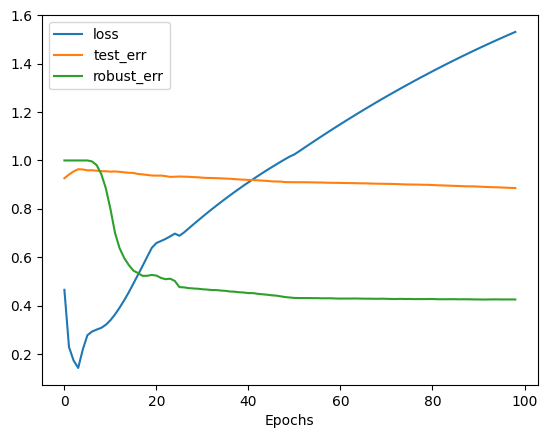

In [25]:
plt.plot(range(len(losses)), losses, label = "loss")
plt.plot(range(len(test_errs)), test_errs, label = "test_err")
plt.plot(range(len(robust_errs)), robust_errs, label = "robust_err")
plt.xlabel("Epochs")
# plt.plot(range(len(training_robust_errs)), training_robust_errs, label=)
plt.legend()
plt.show()

## Verification

In [68]:
def box_verification(model, test_loader, epsilons):
    total_images = len(test_loader.dataset)
    verified_robust = torch.zeros(len(epsilons))
    adversarial_examples = {}
    # Matrix that when multiplied logits by will give max/min o
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1

    for X,y in tqdm.tqdm(test_loader):
        X, y = X.to(device), y.to(device)
        X = X.view(X.size(0), -1)
        for idx, ep in enumerate(epsilons):

            init_bounds = (X - ep, X + ep)
            bounds = bound_propagation(model, init_bounds)
            for i in range(X.shape[0]):
                lower_bound = get_final_bound(model, C[idx], bounds, y==idx)
                is_image_robust = lower_bound.min() == 0
                if is_image_robust: verified_robust[idx] += 1
                # else find adversarial examples
                elif not ep in adversarial_examples.keys():
                    adv_image = pgd_untargeted(model, X[i:i+1], y[i:i+1], 30, ep, 0.01)
                    if adv_image == None:
                        continue
                    else:
                        adversarial_examples[ep] = [X[i].cpu(), adv_image.cpu()]
                    

    return verified_robust/total_images, adversarial_examples


In [82]:
def plot_adv_examples(adversarial_examples, epsilons):
    for eps in epsilons:
        plt.figure()
        plt.title(f'Epsilon = {eps}')
        if adversarial_examples[eps]:
            benign, attacked = adversarial_examples[eps]

            plt.subplot(1, 2, 1)
            plt.imshow(benign.cpu().reshape((28,28)), cmap="gray")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(attacked.cpu().reshape((28,28)), cmap="gray")
            plt.axis('off')
        plt.show()

In [76]:

epsilons = np.linspace(0.01, 0.1, 10)
verified_accuracy, adversarial_examples = box_verification(model, test_loader, epsilons)

for e, a in zip(epsilons, verified_accuracy):
    print(f'Accuracy for {e}: {a}')



100%|██████████| 100/100 [00:37<00:00,  2.69it/s]

Accuracy for 0.01: 0.8100000023841858
Accuracy for 0.020000000000000004: 0.7300000190734863
Accuracy for 0.030000000000000006: 0.10999999940395355
Accuracy for 0.04000000000000001: 0.18000000715255737
Accuracy for 0.05000000000000001: 0.14000000059604645
Accuracy for 0.06000000000000001: 0.09000000357627869
Accuracy for 0.07: 0.1899999976158142
Accuracy for 0.08: 0.2800000011920929
Accuracy for 0.09000000000000001: 0.0
Accuracy for 0.1: 0.0


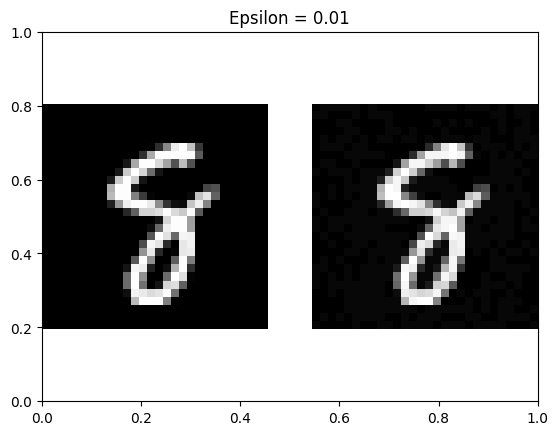

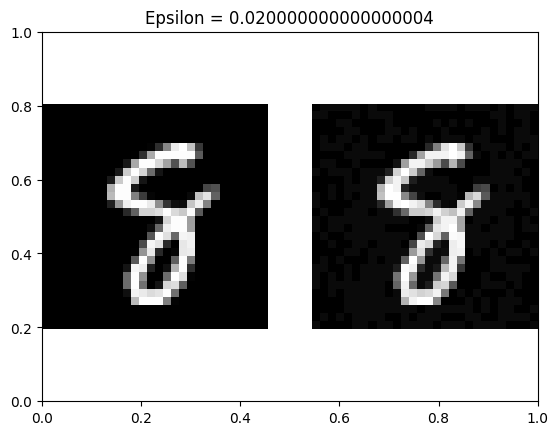

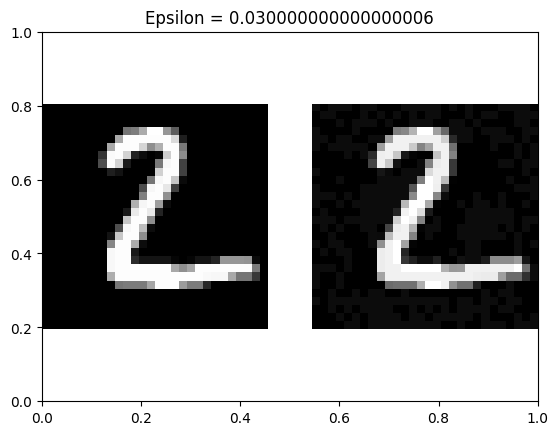

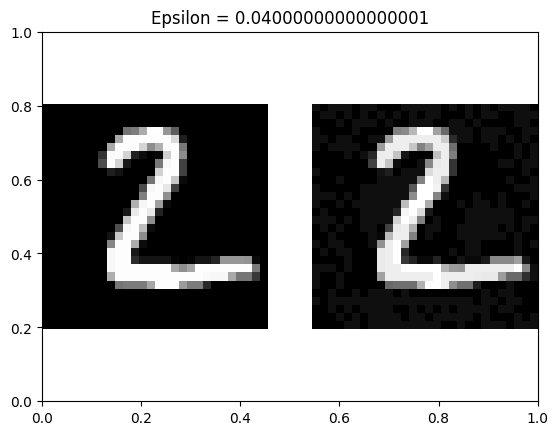

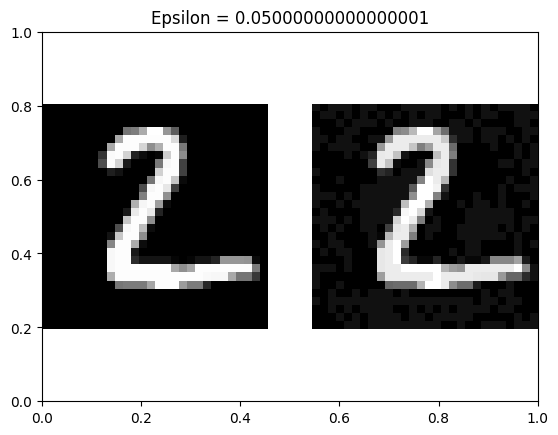

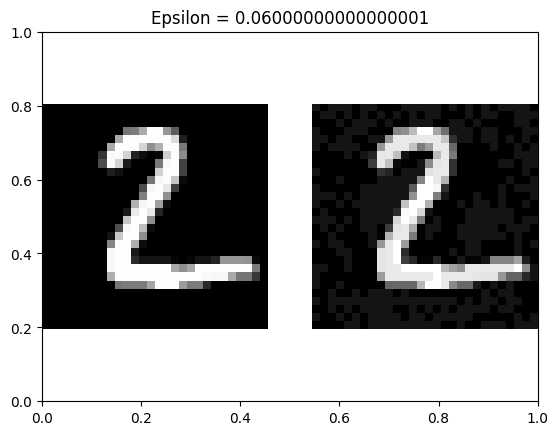

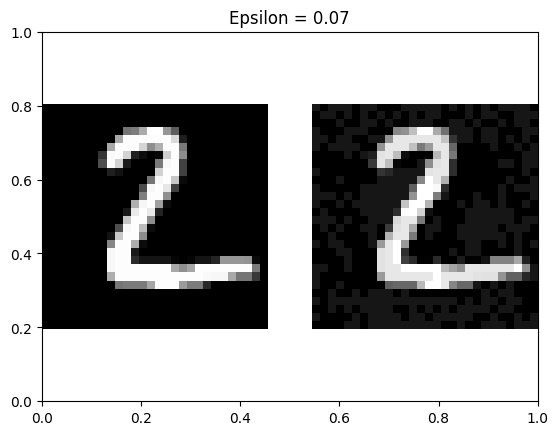

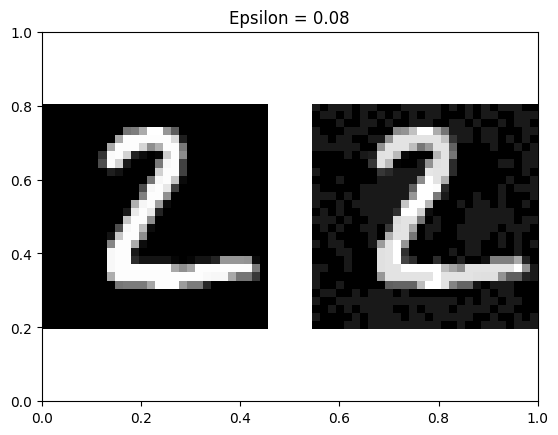

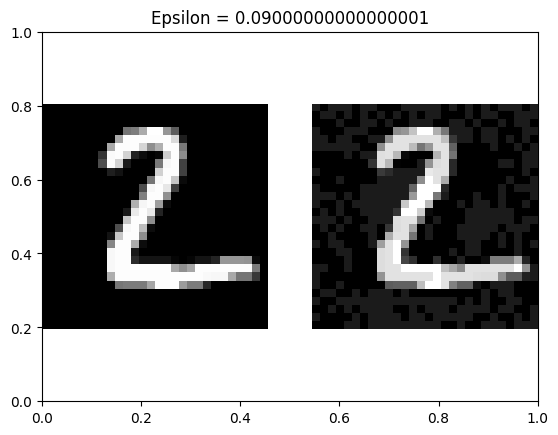

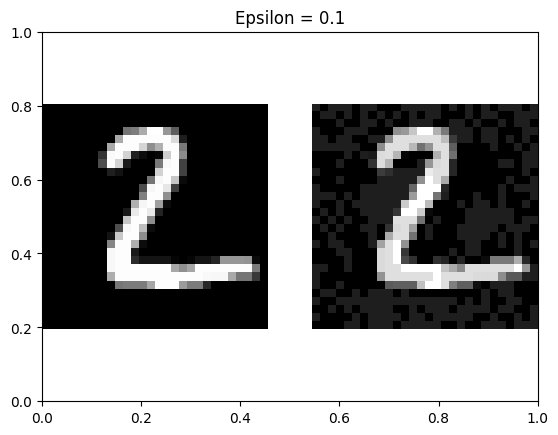

In [83]:

plot_adv_examples(adversarial_examples, epsilons)